Contour #1: Area = 48.0
Contour #2: Area = 27.5
Contour #3: Area = 55.5
Contour #4: Area = 49.0
Contour #5: Area = 152.5
Contour #6: Area = 56.0
Contour #7: Area = 84.5
Contour #8: Area = 42.0
Contour #9: Area = 36.0
Contour #10: Area = 120.5
Contour #11: Area = 49.0
Contour #12: Area = 100.0
Contour #13: Area = 145.5
Contour #14: Area = 255.5
Contour #15: Area = 42.0
Contour #16: Area = 42.0
Contour #17: Area = 71.0
Contour #18: Area = 42.0
Contour #19: Area = 149.5
Contour #20: Area = 42.0
Contour #21: Area = 62.0
Contour #22: Area = 98.0
Contour #23: Area = 55.0
Contour #24: Area = 75.0
Contour #25: Area = 78.5
Contour #26: Area = 48.5
Contour #27: Area = 42.0
Contour #28: Area = 149.0
Contour #29: Area = 161.0
Contour #30: Area = 69.5
Contour #31: Area = 55.0
Contour #32: Area = 211.0
Contour #33: Area = 48.5
Contour #34: Area = 140.5
Contour #35: Area = 42.0
Contour #36: Area = 92.5
Contour #37: Area = 581.5
Contour #38: Area = 48.5
Contour #39: Area = 78.0
Contour #40: Area = 103

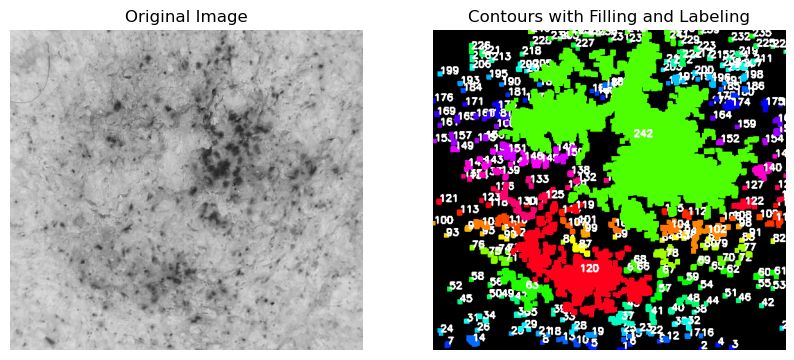

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define the coordinates of the top-left and bottom-right corners of the rectangle
top_left_corner = (200, 250)
bottom_right_corner = (100, 750)

# Function to apply all the processing steps
def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Crop the image
    cropped_image = image[top_left_corner[1]:bottom_right_corner[1], top_left_corner[0]:bottom_right_corner[1]]
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Calculate the Laplacian
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)

    # Normalize the Laplacian image to display
    laplacian_display = cv2.convertScaleAbs(laplacian)

    # Subtract the Laplacian from the original image to get the sharpened image
    sharpened_image = cv2.convertScaleAbs(gray_image - laplacian)

    # Apply a median filter
    kernel_size = 3 
    median_filtered_image = cv2.medianBlur(sharpened_image, kernel_size)

    # Apply min filter
    min_filtered_image = apply_min_filter(median_filtered_image, kernel_size=3)

    # Apply thresholding to ensure the image is binary
    _, binary_image = cv2.threshold(min_filtered_image, 127, 255, cv2.THRESH_BINARY)

    # Create a custom rectangular structuring element (5x5)
    kernel = np.ones((5, 5), dtype=np.uint8)

    # Apply the erosion operation
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)

    # Apply global thresholding
    ret, thresh1 = cv2.threshold(eroded_image, 120, 255, cv2.THRESH_BINARY)

    # Invert the colors
    inverted_image = cv2.bitwise_not(thresh1)

    # Find contours
    contours, hierarchy = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw and fill contours
    contour_image = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)

    # Function to generate a distinct color for each contour
    def get_unique_color(index):
        # Generate a unique color using the HSV color space
        hue = int(255 * (index / len(contours)))  # Vary hue to get distinct colors
        color = cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]
        return tuple(map(int, color))  # Convert color values to integers

    # Loop through the contours and draw them
    for i, contour in enumerate(contours):
        # Calculate the area of each contour
        area = cv2.contourArea(contour)

        # Get a unique color for each contour
        color = get_unique_color(i)

        # Fill each contour with a unique color
        cv2.drawContours(contour_image, [contour], -1, color, thickness=cv2.FILLED)

        # Find the position for labeling the contour index
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            cx, cy = 0, 0

        # Put index number on each contour
        cv2.putText(contour_image, str(i + 1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Print the contour number and the area of each contour
        print(f"Contour #{i + 1}: Area = {area}")

    # Save the contour image
    output_path = f'contour_{os.path.basename(image_path)}'
    cv2.imwrite(output_path, contour_image)

    # Display the original and contour images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Contours with Filling and Labeling")
    plt.imshow(contour_image)
    plt.axis('off')

    plt.show()

# Apply min filter function
def apply_min_filter(image, kernel_size=3):
    # Ensure kernel size is odd to have a central pixel
    assert kernel_size % 2 == 1, "Kernel size must be odd."

    # Calculate padding size needed
    pad_size = kernel_size // 2

    # Pad the image with edge values to handle borders
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REPLICATE)

    # Prepare output images initialized with zeros
    min_filtered_image = np.zeros_like(image)

    # Get image dimensions
    height, width = image.shape

    # Nested loops to apply min and max filters
    for i in range(height):
        for j in range(width):
            # Extracting the 3x3 region around the current pixel
            region = padded_image[i:i + kernel_size, j:j + kernel_size]

            # Apply min filter
            min_filtered_image[i, j] = np.min(region)

    return min_filtered_image

# List of image filenames (assuming images are in the same directory)
image_filenames = glob.glob('F.jpg')

# Process each image
for filename in image_filenames:
    process_image(filename)
